Simple image classification using NNs
=====================================

With a fully connected network

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

For ASCII plots of training progress

In [2]:
import asciichartpy
from IPython.display import clear_output

## Prepares the dataset

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Separate from the CIFAR data only birds and planes

In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## Fully connected NN

- Input features match number of pixels in image
- Output: categorical, number of classes, indicate classification probability

![img description](fig7.7.png)

In [6]:
import torch.nn as nn

In [7]:
n_out = 2

In [8]:
model = nn.Sequential(
            nn.Linear(
                3072,  # <1>
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

### Softmax 

Softmax is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints to represent probabilities. 

#### PyTorch implementantion 

In [9]:
import torch.nn.functional as F

# Example tensor
logits = torch.tensor([1.0, 2.0, 3.0])

# Applying softmax
softmax_output = F.softmax(logits, dim=0)

print(softmax_output)

tensor([0.0900, 0.2447, 0.6652])


In [10]:
softmax_output.sum()

tensor(1.)

#### By hand

Implementing it by hand is easy:

In [11]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [12]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [13]:
softmax(x).sum()

tensor(1.)

#### Another implementation w/ `nn` module

In [14]:
# you need to specify the dimension along which softmax is applied
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

### Equipping NN to output probabilities

Add softmax to the end

In [15]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

### Test on one image

Get one image to test the NN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


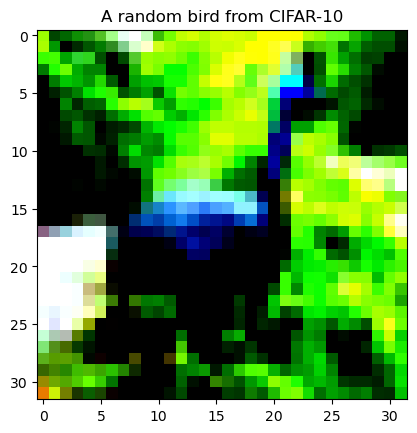

In [16]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.title('A random bird from CIFAR-10')
plt.show()

Turns image into 1D tensor

In [17]:
img_batch = img.view(-1).unsqueeze(0)

Inference from untrained model (random probabilities)

In [18]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

0: airplanes
1: birds

The code below gives the network prediction

In [19]:
_, index = torch.max(out, dim=1)

index

tensor([1])

## Loss for classification

One good choice is the negative log likelihood (NLL) defined as
$$ {\rm NLL} = - \sum_{i=0}^{N} \log p({\rm correct}).$$

Our loss for classification can be computed as follows. For each sample in the batch:

1. Run the forward pass, and obtain the output values from the last (linear) layer.
2. Compute their softmax, and obtain probabilities.
3. Take the predicted probability corresponding to the correct class (the likelihood of the parameters). Note that we know what the correct class is because
it’s a supervised problem—it’s our ground truth.
4. Compute its logarithm, slap a minus sign in front of it, and add it to the loss.

### Comparison between loss definitions 

Not in the book

In [20]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [21]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [22]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [23]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [24]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [25]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [26]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [27]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [28]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9017, 149.8121])

In [29]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [30]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [31]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [32]:
log_softmax(x)

tensor([[-104.,    0.]])

In [33]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

### Modifying the NN

In [36]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [37]:
loss = nn.NLLLoss()

Test the loss with the previous image

In [38]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.7303, grad_fn=<NllLossBackward0>)

## Train the classifier

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

# Use MPS if available, otherwise fall back to CPU
#device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
#model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

### Approach A: updating the model over the whole dataset

This is the most detailed approach. We evaluate the model with the entire dataset. However, it is slow!

In [16]:
%%time
n_epochs = 100

lossList=[]
epochList=[]

for epoch in range(n_epochs):
    for img, label in cifar2:
        # move data to GPU
        #img = img.to(device)
        #img = img.float().to(device)
        #label = torch.tensor([label]).to(device)

        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    lossList.append(np.log10(float(loss)))
    epochList.append(epoch)
    clear_output(wait=True)
    print("              Epoch", epoch, ", Loss",round(float(loss),4))
    print(asciichartpy.plot(lossList, {'height': 10}))

              Epoch 99 , Loss 15.9819
    1.35  ┤     ╭╮╭╮       ╭╮╭╮                               ╭╮╭╮  ╭───╮      ╭╮      ╭╮            ╭╮      ╭
    0.93  ┤ ╭╮╭─╯╰╯╰──╮╭─╮╭╯╰╯╰╮╭───────────────╮╭╮╭╮     ╭╮╭─╯╰╯╰╮╭╯   ╰─╮╭───╯│╭──╮╭─╯╰╮╭╮ ╭╮ ╭╮   │╰╮     │
    0.50  ┼─╯││       ╰╯ ╰╯    ╰╯               ╰╯╰╯╰─╮╭╮╭╯││     ╰╯      ╰╯    ╰╯  ╰╯   │││╭╯│╭╯╰─╮╭╯ │     │
    0.07  ┤  ╰╯                                       ││╰╯ ││                            ╰╯││ ╰╯   ││  │     │
   -0.36  ┤                                           ╰╯   ││                              ╰╯      ││  │╭╮ ╭╮│
   -0.78  ┤                                                ││                                      ││  │││╭╯╰╯
   -1.21  ┤                                                ╰╯                                      ││  ││││
   -1.64  ┤                                                                                        ╰╯  ││││
   -2.07  ┼                                                                     

### Approach C: average updates using minibatches

Here we pick a random subset of the data at each iteration of the training loop. This speeds up convergence, though at the cost of less accurate optimization.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [10]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

In [11]:
lossList=[]
epochList=[]

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    lossList.append(np.log10(float(loss)))
    epochList.append(epoch)
    clear_output(wait=True)
    print("              Epoch", epoch, ", Loss",round(float(loss),4))
    print(asciichartpy.plot(lossList, {'height': 10}))

              Epoch 99 , Loss 0.0188
   -0.23  ┼─╮╭╮╭╮  ╭╮  ╭╮     ╭╮
   -0.43  ┤ ╰╯╰╯│╭─╯╰─╮││ ╭╮╭─╯╰╮   ╭╮  ╭╮     ╭╮
   -0.63  ┤     ╰╯    ╰╯╰─╯╰╯   ╰───╯╰──╯╰╮  ╭╮│╰╮    ╭╮                ╭╮
   -0.84  ┤                               │╭─╯╰╯ ╰─╮╭╮││╭╮ ╭╮ ╭─╮      ╭╯╰╮
   -1.04  ┤                               ╰╯       ╰╯││╰╯│ ││╭╯ ╰╮    ╭╯  │        ╭╮
   -1.24  ┤                                          ╰╯  ╰─╯╰╯   ╰╮ ╭╮│   │╭──╮   ╭╯│╭╮    ╭──╮
   -1.45  ┤                                                       │╭╯╰╯   ╰╯  ╰─╮ │ ││╰──╮ │  │  ╭╮
   -1.65  ┤                                                       ╰╯            ╰─╯ ╰╯   │ │  ╰╮ ││  ╭──╮   ╭─
   -1.85  ┤                                                                              ╰─╯   │╭╯╰╮╭╯  ╰╮╭─╯
   -2.06  ┤                                                                                    ││  ╰╯    ╰╯
   -2.26  ┤                                                                                    ╰╯
   -2.47  ┤


#### Checks accuracy of trained model

Over the training dataset

In [63]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999000


Over the validation dataset

In [64]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.814000


### More complicated architecture

The specification below is the same as with `nn.LogSoftmax` and `nn.NLLLoss`

#### Training again

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

In [134]:
lossList=[]
epochList=[]

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lossList.append(np.log10(float(loss)))
    epochList.append(epoch)

    #print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    clear_output(wait=True)
    print("              Epoch", epoch, ", Loss",round(float(loss),4))
    print(asciichartpy.plot(lossList, {'height': 10}))

              Epoch 99 , Loss 0.0
   -0.09  ┤                 ╭╮              ╭╮╭╮
   -0.44  ┼──────────────╮╭─╯╰╮╭──╮╭╮ ╭╮   ╭╯││╰─╮                                    ╭╮
   -0.79  ┤              ╰╯   ╰╯  ╰╯╰─╯╰╮╭─╯ ╰╯  ╰─╮   ╭╮ ╭╮  ╭╮         ╭╮           ││
   -1.13  ┤                             ╰╯         ╰───╯╰─╯╰╮ ││     ╭╮  ││          ╭╯│          ╭╮
   -1.48  ┤                                                 ╰─╯╰╮    ││  ││╭─╮    ╭╮ │ │          ││╭╮
   -1.83  ┤                                                     ╰──╮ ││ ╭╯╰╯ │╭╮╭─╯╰╮│ ╰╮       ╭─╯│││    ╭╮
   -2.18  ┤                                                        │╭╯╰─╯    ╰╯││   ╰╯  │ ╭───╮ │  ││╰╮ ╭╮││╭╮
   -2.52  ┤                                                        ╰╯          ╰╯       ╰─╯   ╰╮│  ╰╯ ╰─╯╰╯│││
   -2.87  ┤                                                                                    ╰╯          ││╰
   -3.22  ┤                                                                                  

#### Training and validation accuracy

In [135]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999600


In [136]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.808000


#### Model complexity

Number of parameters in NN

In [137]:
sum([p.numel() for p in model.parameters()])

3737474

Number of *trainable* parameters in NN

In [139]:
sum([p.numel() 
     for p in model.parameters() 
     if p.requires_grad == True])

3737474

##### Manual calculation

Here is the manual calculation of the number of parameters for the network below.

```python
      nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))
```

For each layer, the number of parameters is $$N(N_{\rm in},N_{\rm out}) = N_{\rm in} \times N_{\rm out} + N_{\rm out} = N_{\rm out} (1+N_{\rm in} ).$$ 
Thus, for the network above we have

In [145]:
nparam = lambda nin,nout: nout*(1+nin)   

In [153]:
nparam(3072,1024) + nparam(1024,512) + nparam(512,128) + nparam(128,2)

3737474

In [46]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

## Other stuff below

In [47]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [48]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [49]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [50]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [51]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [52]:
conv.bias.shape

torch.Size([16])

In [53]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [54]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


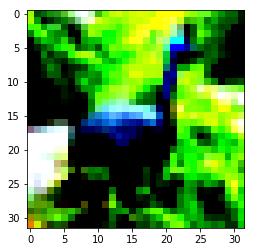

In [55]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

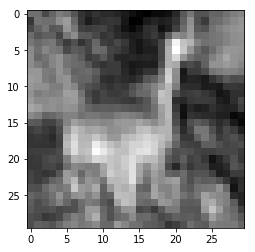

In [56]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [57]:
output.shape

torch.Size([1, 16, 30, 30])

In [58]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [59]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [60]:
with torch.no_grad():
    conv.bias.zero_()

In [61]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

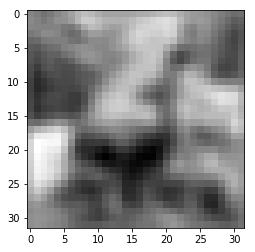

In [62]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [63]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

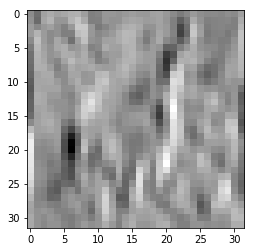

In [64]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [65]:
pool = nn.MaxPool2d(2)

In [66]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [67]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            ...)

TypeError: ellipsis is not a Module subclass

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # WARNING: something missing here
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [ ]:
sum([p.numel() for p in model.parameters()])

In [ ]:
model(img.unsqueeze(0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()

sum([p.numel() for p in model.parameters()])

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
model(img.unsqueeze(0))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
sum([p.numel() for p in model.parameters()])

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))

## Sandbox

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the network and move it to the device
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
for epoch in range(1, 11):  # Train for 10 epochs
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {running_loss / len(train_loader)}")

In [76]:
from asciichartpy import plot
from IPython.display import clear_output
import math
import time

data = []
for i in range(100):
    data.append(math.sin(i * 0.2))
    clear_output(wait=True)
    print(plot(data, {'height': 10}))
    time.sleep(0.1)

    1.00  ┤     ╭────╮                          ╭───╮                          ╭───╮
    0.82  ┤   ╭─╯    ╰╮                       ╭─╯   ╰─╮                      ╭─╯   ╰─╮                       ╭
    0.64  ┤  ╭╯       ╰─╮                    ╭╯       ╰╮                    ╭╯       ╰╮                    ╭─╯
    0.45  ┤ ╭╯          ╰╮                 ╭─╯         ╰╮                  ╭╯         ╰─╮                 ╭╯
    0.27  ┤╭╯            ╰╮               ╭╯            ╰╮                ╭╯            ╰╮               ╭╯
    0.09  ┼╯              ╰╮             ╭╯              ╰╮              ╭╯              ╰╮             ╭╯
   -0.09  ┼                ╰╮           ╭╯                ╰╮            ╭╯                ╰╮           ╭╯
   -0.27  ┤                 ╰╮         ╭╯                  ╰╮          ╭╯                  ╰╮         ╭╯
   -0.45  ┤                  ╰╮       ╭╯                    ╰╮       ╭─╯                    ╰╮       ╭╯
   -0.64  ┤                   ╰─╮   ╭─╯               

In [77]:
np.log10(lossList)

array([-3.94117468, -3.70962428, -3.49444891, ..., -4.11315011,
       -3.92370215, -4.2265296 ])

In [90]:
lossList

[-0.4552634734248416,
 -0.48678398136115225,
 -0.414733637590118,
 -0.4224837288878089,
 -0.4571809803473611,
 -0.42879356789716566,
 -0.2931855981771007,
 -0.3778548369441285,
 -0.5251711890726496,
 -0.41214582237003317,
 -0.4505572984611475,
 -0.3284453445365033,
 -0.4654746553830507,
 -0.38933492799389036,
 -0.4835746420857927,
 -0.5207681185787738,
 -0.39618885706319396,
 -0.3736952421619068,
 -0.26796743439828136,
 -0.41555186256408627,
 -0.5842482480929493,
 -0.30772205131856206,
 -0.4091568567636957,
 -0.3728881372807883,
 -0.45869987623499114,
 -0.4469985926931943,
 -0.49774045381683196,
 -0.49086710833082825,
 -0.2668893421885412,
 -0.3691460480468087,
 -0.4173543907963021,
 -0.45605271938671527,
 -0.4710916099635415,
 -0.20604531427461695,
 -0.39008432369604934,
 -0.4522747409463707,
 -0.3704047431569905,
 -0.4511830592142935,
 -0.33862594177730054,
 -0.45163587220591295,
 -0.5438771708132604,
 -0.3242946740349136,
 -0.3911084138076739,
 -0.39803828292593485,
 -0.466636752746